# Workflow for a district optimization

In this application of the FINE framework, a small district is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [21]:
import FINE as fn
from getData import getData
import pandas as pd
data = getData()

%load_ext autoreload
%autoreload 2
%matplotlib inline  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = data['locations']
commodityUnitDict = {'electricity': 'kW_el', 'methane': 'kW_CH4_LHV','heat':'kW_th'}
commodities = {'electricity','methane','heat'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='€', lengthUnit='m', verboseLogLevel=2)

# 3. Add commodity sources to the energy system model

### Electricity Purchase

In [4]:
esM.add(fn.Source(esM=esM, name='Electricity purchase', commodity='electricity', hasCapacityVariable=False,
                  operationRateMax=data['El Purchase, operationRateMax'], commodityCost=0.298))

### Natural Gas Purchase

In [5]:
esM.add(fn.Source(esM=esM, name='NaturalGas purchase', commodity='methane', hasCapacityVariable=False,
                  operationRateMax=data['NG Purchase, operationRateMax'], commodityCost=0.065))

### PV

In [6]:
esM.add(fn.Source(esM=esM,
                  name='PV',
                  commodity='electricity',
                  hasCapacityVariable=True,
                  hasIsBuiltBinaryVariable=True,
                  operationRateMax=data['PV, operationRateMax'], 
                  capacityMax=data['PV, capacityMax'],
                  interestRate = 0.04,
                  economicLifetime = 20,
                  investIfBuilt=1000,
                  investPerCapacity=1400,
                  opexIfBuilt = 10,
                  bigM = 40))   

# 4. Add conversion components to the energy system model

### Boiler

In [7]:
esM.add(fn.Conversion(esM=esM,
                      name='Boiler',
                      physicalUnit = 'kW_th',
                      commodityConversionFactors={'methane':-1.1, 'heat':1},
                      hasIsBuiltBinaryVariable=True,
                      hasCapacityVariable=True,
                      interestRate = 0.04,
                      economicLifetime = 20,
                      investIfBuilt=2800,
                      investPerCapacity=100,
                      opexIfBuilt = 24,
                      bigM = 200))

# 5. Add commodity storages to the energy system model

### Thermal Storage 

In [8]:
esM.add(fn.Storage(esM=esM,
                   name='Thermal Storage',
                   commodity='heat',
                   selfDischarge=0.001,
                   hasIsBuiltBinaryVariable=True,
                   capacityMax=data['TS, capacityMax'],
                   interestRate = 0.04,
                   economicLifetime = 25,
                   investIfBuilt=23,
                   investPerCapacity=24,
                   bigM = 250))

### Battery Storage

In [9]:
esM.add(fn.Storage(esM=esM,
                   name='Battery Storage',
                   commodity='electricity',
                   cyclicLifetime=10000,
                   chargeEfficiency=0.95,
                   dischargeEfficiency=0.95,
                   chargeRate=0.5,
                   dischargeRate=0.5,
                   hasIsBuiltBinaryVariable=True,
                   capacityMax=data['BS, capacityMax'],
                   interestRate = 0.04,
                   economicLifetime = 12,
                   investIfBuilt=2000,
                   investPerCapacity=700,
                   bigM = 110))

# 6. Add commodity transmission components to the energy system model

### Cable Electricty

In [10]:
esM.add(fn.Transmission(esM=esM,
                        name='E_Distribution_Grid',
                        commodity='electricity',
                        losses=0.00001,
                        distances = data['cables, distances'],
                        capacityFix=data['cables, capacityFix']))

### Natural Gas Pipeline

In [11]:
esM.add(fn.Transmission(esM=esM,
                        name='NG_Distribution_Grid',
                        commodity='methane',
                        distances = data['NG, distances'],
                        capacityFix=data['NG, capacityFix']))

# 7. Add commodity sinks to the energy system model

### Electricity Demand

In [12]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

### Heat Demand

In [13]:
esM.add(fn.Sink(esM=esM, name='BuildingsHeat', commodity='heat',
                hasCapacityVariable=False, operationRateFix=data['Heat demand, operationRateFix']))

# 8. Optimize energy system model

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

In [14]:
esM.cluster(numberOfTypicalPeriods=7)

In [15]:
esM.optimize(timeSeriesAggregation=True, logFileName='', optimizationSpecs='cuts=0 method=2')

Academic license - for non-commercial use only
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Freed default Gurobi environment


# 9. Selected results output

### Sources and Sink

In [16]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

bd1      bd2      bd3  \
Component            Property     Unit                                          
BuildingsHeat        operation    [kW_th*h/a]        213008   211961   212160   
Electricity demand   operation    [kW_el*h/a]         24719  19409.3  24892.8   
Electricity purchase TAC          [€/a]                 NaN      NaN      NaN   
                     commodCosts  [€/a]                 NaN      NaN      NaN   
                     operation    [kW_el*h/a]           NaN      NaN      NaN   
NaturalGas purchase  TAC          [€/a]                 NaN      NaN      NaN   
                     commodCosts  [€/a]                 NaN      NaN      NaN   
                     operation    [kW_CH4_LHV*h/a]      NaN      NaN      NaN   
PV                   TAC          [€/a]              1916.4        0  1853.36   
                     capacity     [kW_el]           17.8889        0   17.277   
                     capexCap     [€/a]             1842.82        0  1779.78   
                     capexIfBuilt [€/a]             73.5818        0  73.5818   
                     invest       [€]               26044.5        0  25187.8   
                     isBuilt      [-]                     1        0        1   
                     operation    [kW_el*h/a]       16130.5        0  15612.6   
                     opexIfBuilt  [€/a]                  10        0       10   

                                                        bd4     bd5      bd6  \
Component            Property     Unit                                         
BuildingsHeat        operation    [kW_th*h/a]        212865  212988   213361   
Electricity demand   operation    [kW_el*h/a]       17439.8   23310  19718.3   
Electricity purchase TAC          [€/a]                 NaN     NaN      NaN   
                     commodCosts  [€/a]                 NaN     NaN      NaN   
                     operation    [kW_el*h/a]           NaN     NaN      NaN   
NaturalGas purchase  TAC          [€/a]                 NaN     NaN      NaN   
                     commodCosts  [€/a]                 NaN     NaN      NaN   
                     operation    [kW_CH4_LHV*h/a]      NaN     NaN      NaN   
PV                   TAC          [€/a]                   0       0  1787.63   
                     capacity     [kW_el]                 0       0  16.6389   
                     capexCap     [€/a]                   0       0  1714.04   
                     capexIfBuilt [€/a]                   0       0  73.5818   
                     invest       [€]                     0       0  24294.4   
                     isBuilt      [-]                     0       0        1   
                     operation    [kW_el*h/a]             0       0  14778.1   
                     opexIfBuilt  [€/a]                   0       0       10   

                                                   grid1 grid2 grid3 grid4  \
Component            Property     Unit                                       
BuildingsHeat        operation    [kW_th*h/a]        NaN   NaN   NaN   NaN   
Electricity demand   operation    [kW_el*h/a]        NaN   NaN   NaN   NaN   
Electricity purchase TAC          [€/a]              NaN   NaN   NaN   NaN   
                     commodCosts  [€/a]              NaN   NaN   NaN   NaN   
                     operation    [kW_el*h/a]        NaN   NaN   NaN   NaN   
NaturalGas purchase  TAC          [€/a]              NaN   NaN   NaN   NaN   
                     commodCosts  [€/a]              NaN   NaN   NaN   NaN   
                     operation    [kW_CH4_LHV*h/a]   NaN   NaN   NaN   NaN   
PV                   TAC          [€/a]              NaN   NaN   NaN   NaN   
                     capacity     [kW_el]            NaN   NaN   NaN   NaN   
                     capexCap     [€/a]              NaN   NaN   NaN   NaN   
                     capexIfBuilt [€/a]              NaN   NaN   NaN   NaN   
                     invest       [€]                NaN   NaN  

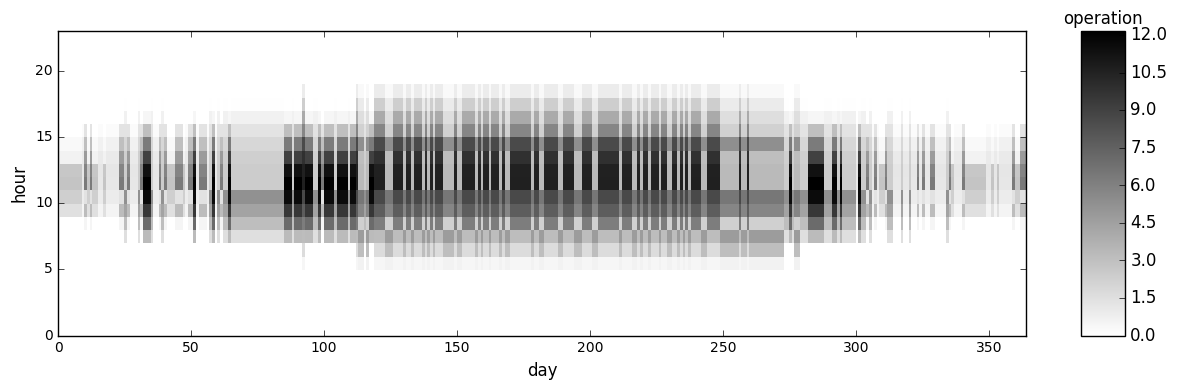

In [22]:
fig, ax = fn.plotOperationColorMap(esM, 'PV', 'bd1')

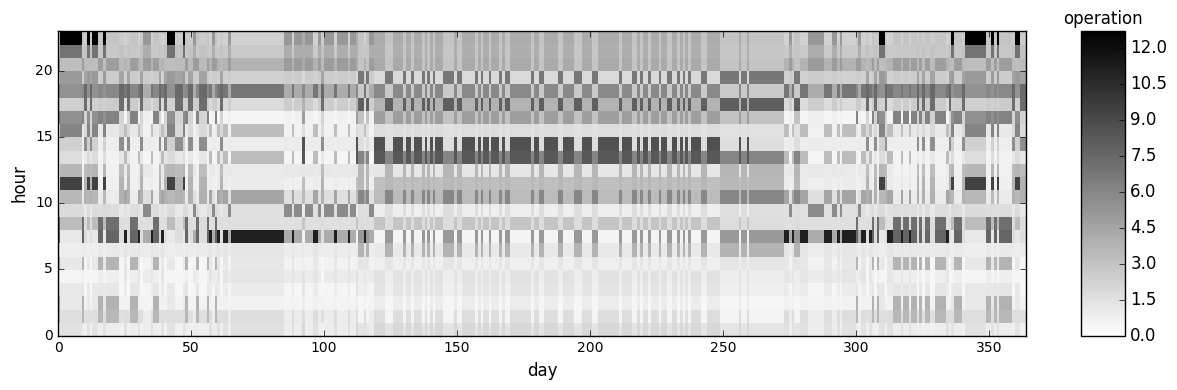

In [23]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'bd1')

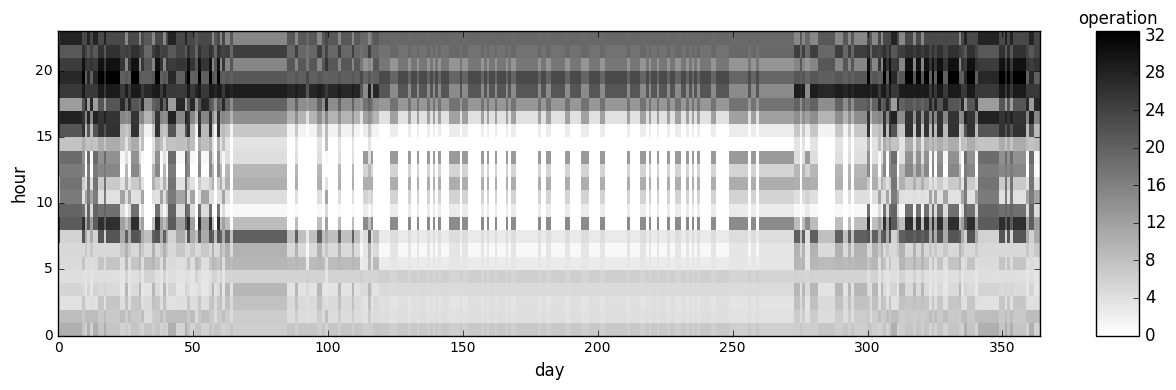

In [24]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity purchase', 'transformer')

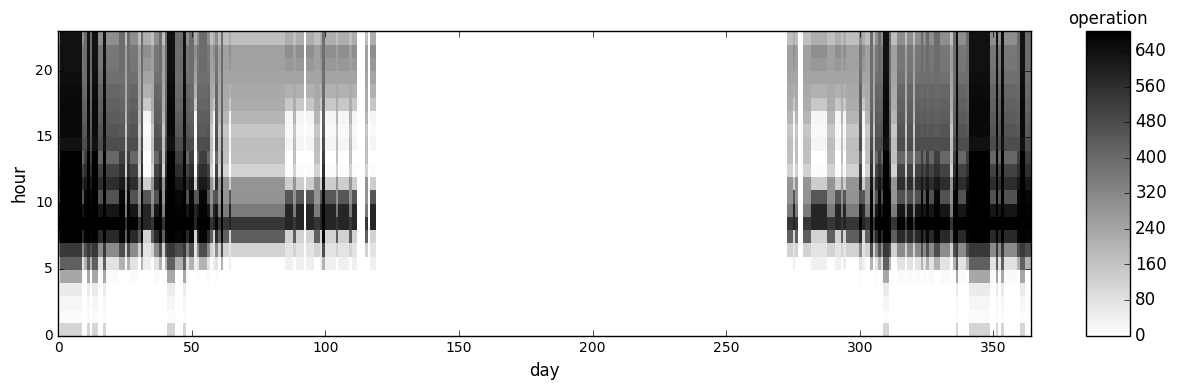

In [25]:
fig, ax = fn.plotOperationColorMap(esM, 'NaturalGas purchase', 'transformer')

### Conversion

In [17]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

bd1      bd2      bd3      bd4  \
Component Property     Unit                                              
Boiler    TAC          [€/a]        878.759  979.311  936.287  1077.52   
          capacity     [kW_th]      91.4262  105.092  99.2445  118.438   
          capexCap     [€/a]         672.73  773.282  730.258  871.489   
          capexIfBuilt [€/a]        206.029  206.029  206.029  206.029   
          invest       [€]          11942.6  13309.2  12724.5  14643.8   
          isBuilt      [-]                1        1        1        1   
          operation    [kW_th*h/a]   213031   211993   212188   212878   
          opexIfBuilt  [€/a]             24       24       24       24   

                                        bd5      bd6 grid1 grid2 grid3 grid4  \
Component Property     Unit                                                    
Boiler    TAC          [€/a]        993.918  955.634     0     0     0     0   
          capacity     [kW_th]      107.077  101.874     0     0     0     0   
          capexCap     [€/a]        787.889  749.605     0     0     0     0   
          capexIfBuilt [€/a]        206.029  206.029     0     0     0     0   
          invest       [€]          13507.7  12987.4     0     0     0     0   
          isBuilt      [-]                1        1     0     0     0     0   
          operation    [kW_th*h/a]   213002   213380     0     0     0     0   
          opexIfBuilt  [€/a]             24       24     0     0     0     0   

                                   grid5 grid6 grid7 transformer  
Component Property     Unit                                       
Boiler    TAC          [€/a]           0     0     0           0  
          capacity     [kW_th]         0     0     0           0  
          capexCap     [€/a]           0     0     0           0  
          capexIfBuilt [€/a]           0     0     0           0  
          invest       [€]             0     0     0           0  
          isBuilt      [-]             0     0     0           0  
          operation    [kW_th*h/a]     0     0     0           0  
          opexIfBuilt  [€/a]           0     0     0           0

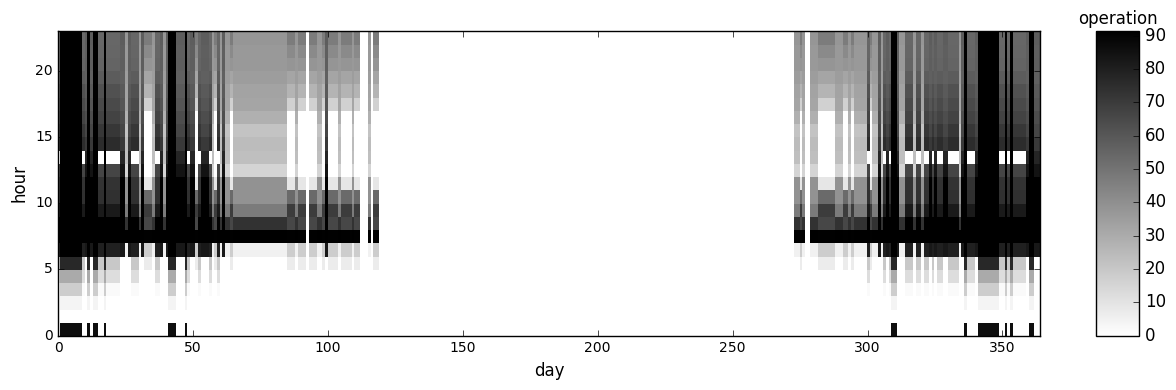

In [26]:
fig, ax = fn.plotOperationColorMap(esM, 'Boiler', 'bd1')

### Storage

In [18]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

bd1      bd2      bd3  \
Component       Property           Unit                                     
Thermal Storage TAC                [€/a]        186.247  287.596  239.629   
                capacity           [kW_th*h]    120.273  186.244  155.021   
                capexCap           [€/a]        184.775  286.123  238.157   
                capexIfBuilt       [€/a]        1.47228  1.47228  1.47228   
                invest             [€]          2909.56  4492.84  3743.51   
                isBuilt            [-]                1        1        1   
                operationCharge    [kW_th*h/a]  9662.53  10509.4  11329.9   
                operationDischarge [kW_th*h/a]  9640.16  10478.1  11301.8   

                                                    bd4      bd5      bd6  \
Component       Property           Unit                                     
Thermal Storage TAC                [€/a]        203.143  160.089  277.432   
                capacity           [kW_th*h]    131.272  103.247  179.628   
                capexCap           [€/a]        201.671  158.616   275.96   
                capexIfBuilt       [€/a]        1.47228  1.47228  1.47228   
                invest             [€]          3173.52  2500.92  4334.07   
                isBuilt            [-]                1        1        1   
                operationCharge    [kW_th*h/a]  6040.31  6124.25  10010.6   
                operationDischarge [kW_th*h/a]  6027.41  6110.07  9990.87   

                                               grid1 grid2 grid3 grid4 grid5  \
Component       Property           Unit                                        
Thermal Storage TAC                [€/a]         NaN   NaN   NaN   NaN   NaN   
                capacity           [kW_th*h]     NaN   NaN   NaN   NaN   NaN   
                capexCap           [€/a]         NaN   NaN   NaN   NaN   NaN   
                capexIfBuilt       [€/a]         NaN   NaN   NaN   NaN   NaN   
                invest             [€]           NaN   NaN   NaN   NaN   NaN   
                isBuilt            [-]           NaN   NaN   NaN   NaN   NaN   
                operationCharge    [kW_th*h/a]   NaN   NaN   NaN   NaN   NaN   
                operationDischarge [kW_th*h/a]   NaN   NaN   NaN   NaN   NaN   

                                               grid6 grid7 transformer  
Component       Property           Unit                                 
Thermal Storage TAC                [€/a]         NaN   NaN         NaN  
                capacity           [kW_th*h]     NaN   NaN         NaN  
                capexCap           [€/a]         NaN   NaN         NaN  
                capexIfBuilt       [€/a]         NaN   NaN         NaN  
                invest             [€]           NaN   NaN         NaN  
                isBuilt            [-]           NaN   NaN         NaN  
                operationCharge    [kW_th*h/a]   NaN   NaN         NaN  
                operationDischarge [kW_th*h/a]   NaN   NaN         NaN

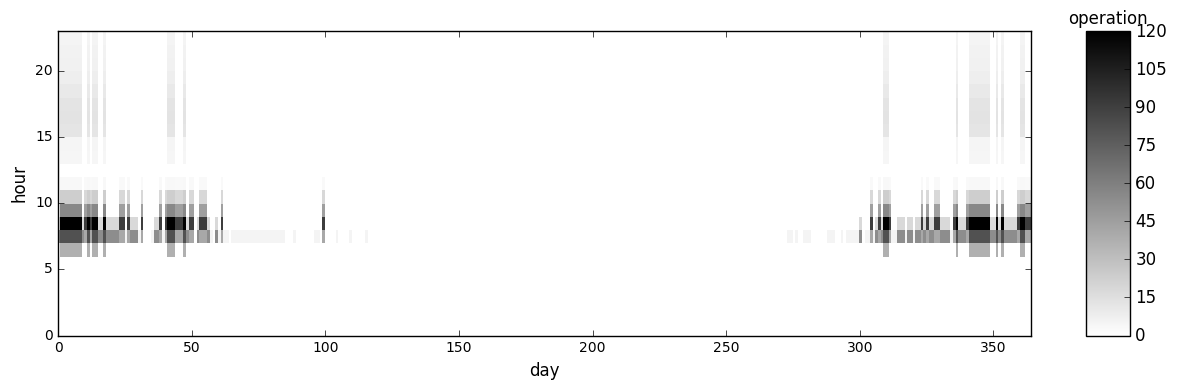

In [28]:
fig, ax = fn.plotOperationColorMap(esM, 'Thermal Storage', 'bd1', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

### Transmission

In [19]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2)

bd1  \
E_Distribution_Grid  capacity  [kW_el]          bd1                 None   
                                                bd2                 None   
                                                bd3                 None   
                                                bd4                 None   
                                                bd5                 None   
                                                bd6                 None   
                                                grid1              10000   
                                                grid2               None   
                                                grid3               None   
                                                grid4               None   
                                                grid5               None   
                                                grid6               None   
                                                grid7               None   
                                                transformer         None   
                     operation [kW_el*h/a]      bd1                 None   
                                                bd2                 None   
                                                bd3                 None   
                                                bd4                 None   
                                                bd5                 None   
                                                bd6                 None   
                                                grid1        3.04924e+06   
                                                grid2               None   
                                                grid3               None   
                                                grid4               None   
                                                grid5               None   
                                                grid6               None   
                                                grid7               None   
                                                transformer         None   
NG_Distribution_Grid capacity  [kW_CH4_LHV]     bd1                 None   
                                                bd2                 None   
                                                bd3                 None   
                                                bd4                 None   
                                                bd5                 None   
                                                bd6                 None   
                                                grid1              10000   
                                                grid2               None   
                                                grid3               None   
                                                grid4               None   
                                                grid5               None   
                                                grid6               None   
                                                grid7               None   
                                                transformer         None   
                     operation [kW_CH4_LHV*h/a] grid1             234334   
                                                grid2               None   
                                                grid3               None   
                                                grid4               None   
                                                grid5               None   
                                                grid6               None   
                                                grid7               None   
                                                transformer         None   

                                                                     bd2  \
E_Distribution_Grid  capacity  [kW_el]          bd1                 None   
                                        